# Seattle cloud aerosol-cloud μ-physics modelling mini-workshop 2026

## Part 1: droplet condensational growth in an adiabatic parcel model

### • imports and Pint dimensional-analysis setup (physical units)

In [1]:
import pint, scipy, numpy, mendeleev, ipywidgets
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_anim

In [2]:
si = pint.UnitRegistry()
si.setup_matplotlib()

### • physical constants and basic formulae

In [3]:
class Physics:
    M_a = (
        0.78 * 2 * mendeleev.N.atomic_weight * si.g / si.mole + 
        0.21 * 2 * mendeleev.O.atomic_weight * si.g / si.mole + 
        0.01 * 2 * mendeleev.Ar.atomic_weight * si.g / si.mole
    )
    M_v = (
        1 * mendeleev.O.atomic_weight * si.g / si.mole + 
        2 * mendeleev.H.atomic_weight * si.g / si.mole
    )
    
    R_str = scipy.constants.R * si.J / si.K / si.mole
    
    R_a = R_str / M_a
    R_v = R_str / M_v
    
    g = scipy.constants.g * si.m / si.s**2
    
    l_v = 2.5e6 * si.J / si.kg
    c_p  = 1000 * si.J / si.kg / si.K
    
    D = 2.26e-5 * si.m**2 / si.s
    rho_w = 1 * si.kg / si.litre

    # saturation vapour pressure polynomial fit from Flatau et al. 1992
    # https://doi.org/10.1175/1520-0450(1992)031<1507%3APFTSVP>2.0.CO%3B2
    c_w = (6.115836990e000, 0.444606896e000, 0.143177157e-01, 0.264224321e-03, 0.299291081e-05,
           0.203154182e-07, 0.702620698e-10, 0.379534310e-13, -.321582393e-15)        
    
    @staticmethod
    def p_eq(T):
        return numpy.polynomial.polynomial.polyval(T.to(si.celsius).magnitude, Physics.c_w) * si.hPa
    
    @staticmethod
    def rho(p, R, T):
        return p / (R * T)

    @staticmethod
    def lognormal(r, n_tot, r_m, gstdev):
        return n_tot / r \
          * numpy.exp(-pow((numpy.log(r/r_m)), 2)/2 / pow(numpy.log(gstdev),2)) \
          / numpy.log(gstdev) \
          / numpy.sqrt(2*numpy.pi)

### • a storage class inheriting from NumPy.ndarray and compatible with both SciPy and Pint APIs

In [4]:
class Storage:
    class __Impl(numpy.ndarray):
        p_idx, p_unit = 0, si.hPa
        T_idx, T_unit = 1, si.K
        m_unit = si.g
        z_unit = si.m
        
        @property
        def m_idx(self):
            return slice(2, self.shape[0])
        
        @property
        def p(self):
            return self[self.p_idx] * self.p_unit

        @p.setter
        def p(self, value):
            self[self.p_idx] = (value.to(self.p_unit) / self.p_unit).magnitude

        @property
        def T(self):
            return self[self.T_idx] * self.T_unit

        @T.setter
        def T(self, value):
            self[self.T_idx] = (value.to(self.T_unit) / self.T_unit).magnitude

        @property
        def m(self):
            return self[self.m_idx] * self.m_unit

        @m.setter
        def m(self, value):
            self[self.m_idx] = (value.to(self.m_unit) / self.m_unit).magnitude
    
    @staticmethod
    def make_state(n_particles):
        return Storage.__Impl(shape=2 + n_particles)

    @staticmethod
    def make_deriv(state):
        storage = Storage.__Impl(shape=state.shape)
        storage.p_unit /= storage.z_unit
        storage.T_unit /= storage.z_unit
        storage.m_unit /= storage.z_unit
        return storage
    
    @staticmethod
    def view_state(array):
        storage = Storage.__Impl(shape=array.shape)
        storage[:] = array[:]
        return storage

### • ODE system expressing drop mass and pressure & temperature dynamics

$$
\begin{eqnarray}
  \frac{dp}{dz} &=& - \rho g \\
  \frac{dm_i}{dz} &=& \frac{\xi_i}{w} \max\!\!\left[0,\,\,\frac{4\pi r_i^2}{r_i} D (\rho_v - \rho_{eq})\right]\\ &=& \frac{\xi_i}{w}\max\!\!\left[0,\,\,(4 \pi)^{2/3} \sqrt[3]{\frac{3m_i}{\xi_i\rho_w}}\,D \left(\rho_v - \frac{p_{eq}(T)}{R_v T}\right)\right]\\
  \vdots\\
  \frac{dT}{dz} &=& \frac{1}{c_p} \left(\frac{1}{\rho}\frac{dp}{dz} + \frac{l_v}{m_a} \sum_i \frac{dm_i}{dz} \right)
\end{eqnarray}
$$

$p$: hydrostatic pressure in the adiabatic air parcel
$z$: parcel displacement    
$\rho$: air density   
$g$: gravitational acceleration   
$r_i$: super-droplet radius attribute $i$
$m_i$: mass of all droplets represented by a super-droplet $i$   
$\xi_i$: multiplicity of super-droplet $i$       
$\rho_v$: ambient vapour density
$\rho_{eq}$: saturated vapour density
$T$: temperature   
$c_p$: specific heat of air (under constant pressure)   
$l_v$: latent heat of water vapourisation   
$m_a$: mass of air in the air parcel

### • SciPy-compatible ODE system implementation

In [12]:
class System:
    def __init__(self, pv0, volume, updraft, xi, state):
        self.m_a = Physics.rho(state.p, Physics.R_a, state.T) * volume
        self.m_w = Physics.rho(pv0, Physics.R_v, state.T) * volume \
                 + numpy.sum(state.m) 
        self.updraft = updraft
        self.xi = xi
        
    def __call__(self, z, state, progbar):
        progbar.value = z
        state = Storage.view_state(state)
        deriv = Storage.make_deriv(state)
            
        rho = Physics.rho(state.p, Physics.R_a, state.T)
        volume = self.m_a / rho
        rho_eq = Physics.p_eq(state.T) / Physics.R_v / state.T
        rho_v = (self.m_w - numpy.sum(state.m)) / volume

        # ambient pressure dynamics (hydrostatic profile)
        deriv.p = -Physics.rho(state.p, Physics.R_a, state.T) * Physics.g
        
        # droplet mass dynamics expressed using Fick's law for diffusion of vapour in air around the droplet
        deriv.m = self.xi / self.updraft * (4*numpy.pi)**(2/3) \
            * (3*state.m / self.xi / Physics.rho_w)**(1/3) \
            * Physics.D * (rho_v - rho_eq)
        deriv.m = (deriv.m + numpy.abs(deriv.m)) / 2
            
        # ambient air heat budget (latent heat release vs. adiabatic cooling)
        deriv.T = (deriv.p/rho + numpy.sum(deriv.m) / self.m_a * Physics.l_v) / Physics.c_p
                            
        return deriv

### • numerical solution using SciPy

In [13]:
def solve(system, state, displacement, max_step):
    display(progbar := ipywidgets.FloatProgress(max=displacement / state.z_unit))
    integ = scipy.integrate.solve_ivp(
        system, 
        [0, displacement / state.z_unit], 
        state,
        max_step=(max_step / state.z_unit).magnitude,
        args=(progbar,),
    )
    assert integ.success, integ.message
    return Storage.view_state(integ.y), integ.t * state.z_unit

### • sample simulation

In [14]:
radii, dr = tuple([x * si.nm for x in numpy.linspace(400, 2200, num=32, retstep=True)]) 
n_n = Physics.lognormal(r=radii, n_tot=50 / si.cm**3, r_m = 1*si.um, gstdev=1.3)

volume = 1 * si.m**3
xi = n_n * dr * volume
updraft = .5 * si.m / si.s

state = Storage.make_state(len(radii))
state.p = 1000 * si.hPa
state.T = 300 * si.K
state.m = 4/3 * numpy.pi * Physics.rho_w * xi * radii**3

system = System(pv0=.995 * Physics.p_eq(state.T), volume=volume, updraft=updraft, xi=xi, state=state)
solution, zsteps = solve(system, state, 50 * si.m, max_step = 1 * si.m)

FloatProgress(value=0.0, max=50.0)

### • animated visualisation

FloatProgress(value=0.0, max=51.0)


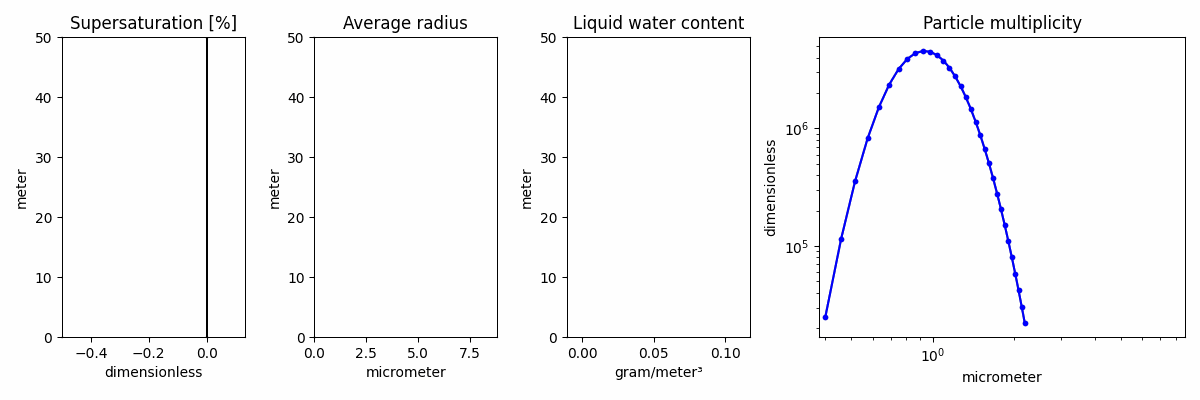

HTML(value="<a href='./tmp5vzr3q0w.gif' target='_blank'>./tmp5vzr3q0w.gif</a><br>")

In [15]:
display(progbar := ipywidgets.FloatProgress(max=len(zsteps) - 1))
def plot(frame: int):
    progbar.value = frame
    fig, axs = pyplot.subplot_mosaic(
        mosaic=[["S", "R", "LWC", "spectrum"]],
        gridspec_kw={"width_ratios": [1, 1, 1, 2]},
        figsize=(12, 4),
        tight_layout=True
    )
    
    m_v = system.m_w - numpy.sum(solution.m, axis=0)
    volume = system.m_a / Physics.rho(solution.p, Physics.R_a, solution.T) 

    p_v = m_v / volume * Physics.R_v * solution.T
    p_eq = Physics.p_eq(solution.T)
    supersaturation = 100 * (p_v / p_eq - 1)
    
    axs["S"].step(supersaturation[:frame], zsteps[:frame])
    axs["S"].vlines(0, ymin=zsteps[0], ymax=zsteps[-1], color='black')
    axs["S"].set(
        xlim=(supersaturation[0], 1.1 * max(supersaturation)),
        ylim=(0, zsteps[-1]),
        title='Supersaturation [%]',
    )
    
    xi_2d = xi.reshape(-1, 1).repeat(zsteps.shape[0], axis=1)
    rads = (solution.m / xi_2d * 3 / 4 / numpy.pi / Physics.rho_w)**(1/3)
    mean_r = numpy.sum(rads * xi_2d, axis=0) / numpy.sum(xi)
    axs["R"].step(mean_r[:frame], zsteps[:frame])
    axs["R"].xaxis.set_units(si.um)
    axs["R"].set(
        xlim=(0, 1.1 * max(mean_r)), 
        ylim=(0, zsteps[-1]),
        title='Average radius',
    )

    lwc = (system.m_w - m_v) / volume
    axs["LWC"].step(lwc[:frame], zsteps[:frame])
    axs["LWC"].xaxis.set_units(si.g / si.m**3)
    axs["LWC"].set(
        xlim=(-.1 * max(lwc), 1.1 * max(lwc)),
        ylim=(0, zsteps[-1]),
        title='Liquid water content',
    )

    axs["spectrum"].plot(rads[:, 0], xi, color='gray', marker='.')
    axs["spectrum"].plot(rads[:, frame], xi, color='blue', marker='.')
    axs["spectrum"].xaxis.set_units(si.um)
    axs["spectrum"].yaxis.set_units(si.dimensionless)
    axs["spectrum"].set(
        xlim=(.95 * numpy.amin(rads), 1.05 * numpy.amax(rads)),
        title='Particle multiplicity',
        xscale='log',
        yscale='log',
    )
    
    return fig
show_anim(plot, frame_range=range(1, len(zsteps)))